In [1]:
import os, json

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfl = tf.keras.layers
tfs = tf.summary

import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

In [69]:
mm = ManifoldVAE()
mm.decoder(tf.random.uniform((1, 64)), training=True)

<function leaky_relu at 0x7fee4d8db378>


<tf.Tensor: id=55595509, shape=(1, 1024), dtype=float32, numpy=
array([[0.5433307 , 0.4894673 , 0.577988  , ..., 0.49115962, 0.48334962,
        0.5623177 ]], dtype=float32)>

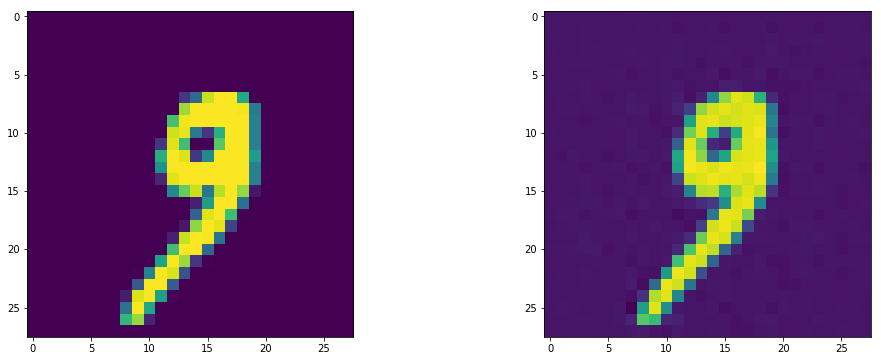

In [7]:
idx = 1000

im = eval_data[idx:idx + 1]
z_1 = manifold_vae.encoder(mnist_parse_fn(im), training=False)
#z_2 = measure_vae.encoder(z_1)
#z_2 = measure_vae.posterior.sample()
# z = tf.ones((1, 64))
#z = vae.posterior.sample()
#z = measure_vae.decoder(z_2)
#print(z_2)
#print(z_1)
#print(z)
rec_im = manifold_vae.decoder(z_1, training=False)

plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.imshow(im[0])

plt.subplot(122)
plt.imshow(tf.squeeze(rec_im))

plt.show()